In [327]:
import os
from random import randint
import uuid
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import yaml
from munch import Munch
import random
import numpy as np

from eval import get_run_metrics
from tasks import get_task_sampler
from samplers import get_data_sampler
from models import build_model

import torch.nn as nn
import torch.optim as optim


from hook_model import hook_model, search_heads_get_loss, get_model, get_data, get_acts, PassThroughEmbed 

from fancy_einsum import einsum                                                                                                                                                                   
import torch
import numpy as np
from torch import nn
import wandb

import transformer_lens.utils as utils
import plotly.express as px
from samplers import get_data_sampler
from tasks import get_task_sampler
from eval import get_model_from_run, get_run_metrics
torch.backends.cudnn.benchmark = True

import logging

def get_model(path, device="cpu"):
    class PassThroughEmbed(nn.Module):
        def __init__(self, cfg=None):
            super().__init__()
            # No parameters needed, but constructor accepts cfg for compatibility

        def forward(self, tokens):
            # Directly return the input without any modifications
            return tokens

    model = torch.load(path, map_location=device)
    tl_model = model.to(device)
    tl_model.set_use_attn_result(True)
    tl_model.set_use_split_qkv_input(True)
    if "use_hook_mlp_in" in tl_model.cfg.to_dict():
        tl_model.set_use_hook_mlp_in(True)
    return tl_model

device = torch.device('cpu')
# Set the logging level to ERROR to ignore warnings
logging.getLogger().setLevel(logging.ERROR)

def validation_metric(predictions, labels, return_one_element, device):
    predictions = predictions.to(device)

    # loss is mse on last 5 predictions (full context)
    loss = (labels.to(device) - predictions.to(device)).square().cpu().numpy().mean(axis=0)[-5:].mean()
    return loss

def straight_loss(predictions, labels, device):
    predictions = predictions.to(device)

    # loss is mse on last 5 predictions (full context)
    loss = (labels.to(device) - predictions.to(device)).square().cpu().numpy().mean(axis=0).mean()
    return loss

def plot_loss(pred, labels, conf, device):

    loss = (labels.to(device) - pred.to(device)).square().cpu().numpy()

    baseline = {
        "linear_regression": conf.model.n_dims,
    }[conf.training.task]

    plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
    plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
    plt.xlabel("# in-context examples")
    plt.ylabel("squared error")
    plt.legend()
    plt.show()

def test_model(device, conf, model, read_in_weight, read_in_bias, graph=False):
    input, _, labels, _ = get_data(conf, read_in_weight, read_in_bias)

    with torch.no_grad():
        my_pred = model(input)[:, ::2, 0][:, torch.arange(labels.shape[1])].cpu() # this last transformation before returning is in the original and I assume only selects the predictions for ys
    
    mse_on_last_5 = validation_metric(my_pred, labels, True, device)
    total_loss = straight_loss(my_pred, labels, device)

    if graph:
        plot_loss(my_pred, labels, conf, device)

    return mse_on_last_5, total_loss

In [326]:
config_path = "config.yaml" # nuvolous path: "data_and_model/analyse/config.yaml"
with open(config_path) as fp:  # we don't Quinfig it to avoid inherits
    conf = Munch.fromDict(yaml.safe_load(fp))
model = get_model('./weights/last_final_toy_model.pt', device) # nuvolous path: 'data_and_model/analyse/toy_model.pt'
read_in_weight = torch.load('./weights/last_final_toy_read_in_weight.pt', map_location=device) # nuvolous path: 'data_and_model/analyse/toy_read_in_weight.pt'
read_in_bias = torch.load('./weights/last_final_toy_read_in_bias.pt', map_location=device) # nuvolous path: 'data_and_model/analyse/toy_read_in_bias.pt'

Moving model to device:  cpu


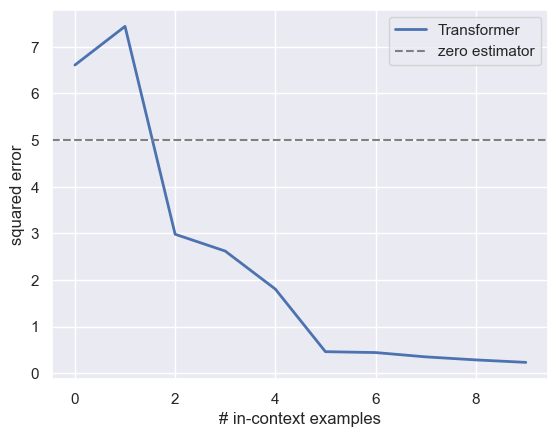

(0.35425085, 2.3210912)

In [328]:
test_model(device, conf, model, read_in_weight, read_in_bias, True)

In [137]:
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

# Norm head analysis

In [139]:
excluded_loss, restricted_loss, selected_head, total_scores = search_heads_get_loss(model, conf, read_in_weight, read_in_bias)

In [140]:
excluded_loss, restricted_loss, selected_head, total_scores

(tensor(9.0171),
 tensor(1.7086),
 (0, 0),
 tensor([[0.6893, 0.4190],
         [0.6953, 0.5995],
         [0.1590, 0.1121]], grad_fn=<MeanBackward1>))

In [141]:
norm_scores = total_scores.detach().numpy()

In [142]:
imshow(total_scores, xaxis="Head", yaxis="Layer", title="Norm Score for each head", zmax=1.0, zmin=-1.0)

causal

In [143]:
device = torch.device('cpu')
import torch.nn.functional as F

def validation_metric(predictions, labels, return_one_element, device):
    predictions = predictions.to(device)

    # loss is mse on last 5 predictions (full context)
    loss = (labels.to(device) - predictions.to(device)).square().cpu().detach().numpy().mean(axis=0)[-5:].mean()
    return loss

def prep_manual_input(xs, ys):
    batch, n_ctx, d_xs = xs.shape

    ys_wide = torch.cat(
        (
            ys.view(batch, n_ctx, 1),
            torch.zeros(batch, n_ctx, d_xs - 1, device=ys.device),
        ),
        axis=2,
    )
    my_zs = torch.stack((xs, ys_wide), dim=2)
    my_zs = my_zs.view(batch, 2 * n_ctx, d_xs).to(device)

    zeros_to_append = torch.zeros(my_zs.shape[0], my_zs.shape[1], conf.model.n_dims - my_zs.shape[2])

    my_zs = torch.cat((my_zs.to(device), zeros_to_append.to(device)), dim=2)

    # apply the read_in transformation
    transformed_zs = einsum("batch n_ctx d_xs, d_model d_xs -> batch n_ctx d_model", my_zs, read_in_weight) + read_in_bias

    # apply padding

    current_len = transformed_zs.shape[1]
    max_len = 64 # HORRID tech debt I don't get
    pad_len = max(max_len - current_len, 0)

    

    # Apply padding to the right of the second dimension
    # The padding order in F.pad is (left, right, top, bottom) for 4D input, but here it's the equivalent for 3D
    return F.pad(transformed_zs, (0, 0, 0, pad_len), "constant", 0)


In [144]:
# baseline stuff, don't change
xs = torch.tensor([[[1, 1, 1] for i in range(10)]])
ys = torch.tensor([[1 for i in range(10)]])

manual_baseline_input = prep_manual_input(xs, ys)

baseline_output, baseline_cache = model.run_with_cache(manual_baseline_input)
baseline_output = baseline_output[:, ::2, 0][:, torch.arange(ys.shape[1])].cpu()
validation_metric(baseline_output, ys, False, 'cpu')

0.046146598

In [145]:
corrupt_xs = torch.tensor([[[2, 2, 2] for i in range(10)]])
corrupt_ys = torch.tensor([[2 for i in range(10)]])

manual_corrupt_input = prep_manual_input(corrupt_xs, corrupt_ys)

corrupt_output, corrupt_cache = model.run_with_cache(manual_corrupt_input)
corrupt_output = corrupt_output[:, ::2, 0][:, torch.arange(ys.shape[1])].cpu()
validation_metric(corrupt_output, corrupt_ys, False, 'cpu')

0.4286701

In [146]:
from jaxtyping import Float
from transformer_lens.hook_points import (
    HookPoint,
)  # Hooking utilities

layer = 0
head = 0

def get_hooked_preds(input, labels, old_cache, nex_cache):
    '''
    Mind this function only replaces the embedding!!
    we are patching in new xs in A00
    likely we are gonna need to adjust for subsequent components
    '''

    model.reset_hooks()

    def xs_attn0_patching_hook(
        resid_pre: Float[torch.Tensor, "batch pos d_model"],
        hook: HookPoint,
    ) -> Float[torch.Tensor, "batch pos d_model"]:
        # Each HookPoint has a name attribute giving the name of the hook.
        
        corrupt_embedding = nex_cache[f'blocks.{str(layer)}.hook_resid_pre']
        clean_embedding = old_cache[f'blocks.{str(layer)}.hook_resid_pre']

        # ::2 for xs
        resid_pre[:, ::2, head, :] = resid_pre[:, ::2, head, :] - clean_embedding[:, ::2, :] + corrupt_embedding[:, ::2, :]
        return resid_pre

    head_0_xs_patched_preds = model.run_with_hooks(input, fwd_hooks=[
        (utils.get_act_name('blocks.0.hook_v_input'), xs_attn0_patching_hook)
    ])[:, ::2, 0][:, torch.arange(labels.shape[1])].cpu()
    head_0_xs_ablated_loss = validation_metric(head_0_xs_patched_preds, labels, False, 'cpu')

    model.reset_hooks()
    return head_0_xs_patched_preds

In [147]:
get_hooked_preds(manual_baseline_input, ys, baseline_cache, corrupt_cache)

tensor([[0.0459, 0.5640, 0.3017, 0.0985, 0.0548, 0.0792, 0.1343, 0.2283, 0.3135,
         0.3481]], grad_fn=<IndexBackward0>)

## show attn patter again

In [148]:
OV_circuit_all_heads = model.OV
O = model.blocks[0].attn.W_O[0]
V = model.blocks[0].attn.W_V[0]
OV = torch.matmul(O, V)

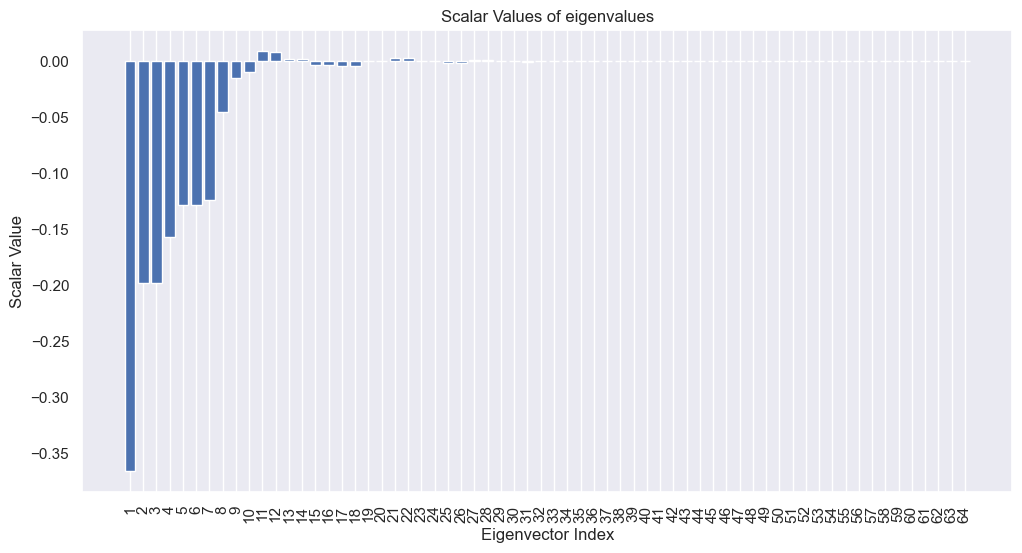

In [149]:
eigvalues = torch.linalg.eig(OV_circuit_all_heads.AB[0, 0].cpu()).eigenvalues.to(torch.float32).to('cpu')
plt.figure(figsize=(12, 6))
plt.bar(range(1, 65), eigvalues.detach())
plt.title('Scalar Values of eigenvalues')
plt.xlabel('Eigenvector Index')
plt.ylabel('Scalar Value')
plt.xticks(range(1, 65), rotation=90)  # Adjusting x-axis labels for clarity
plt.grid(axis='y')
plt.show()

In [247]:
eigvalues.sum()

tensor(-1.3669, grad_fn=<SumBackward0>)

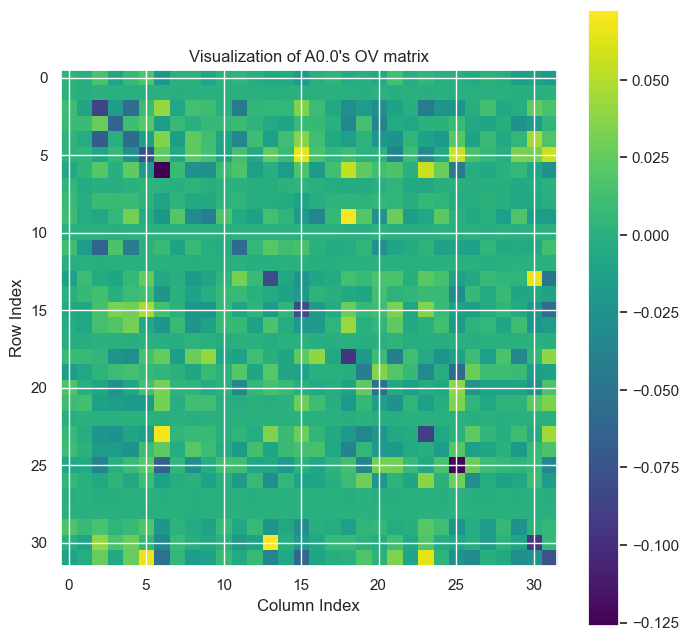

In [150]:
plt.figure(figsize=(8, 8))
plt.imshow(OV.detach().cpu(), cmap='viridis')
plt.colorbar()
plt.title("Visualization of A0.0's OV matrix")
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

In [151]:
eig_input, eig_xs, eig_ys, w = get_data(conf, read_in_weight, read_in_bias)

symmetry

In [152]:
torch.abs(OV_circuit_all_heads.AB[0, 0] - OV_circuit_all_heads.AB[0, 0].T).mean()

tensor(0.0149, grad_fn=<MeanBackward0>)

In [153]:
eigs = torch.linalg.eig(OV_circuit_all_heads.AB[0, 0].cpu()).eigenvectors.to(torch.float32).to('cpu')

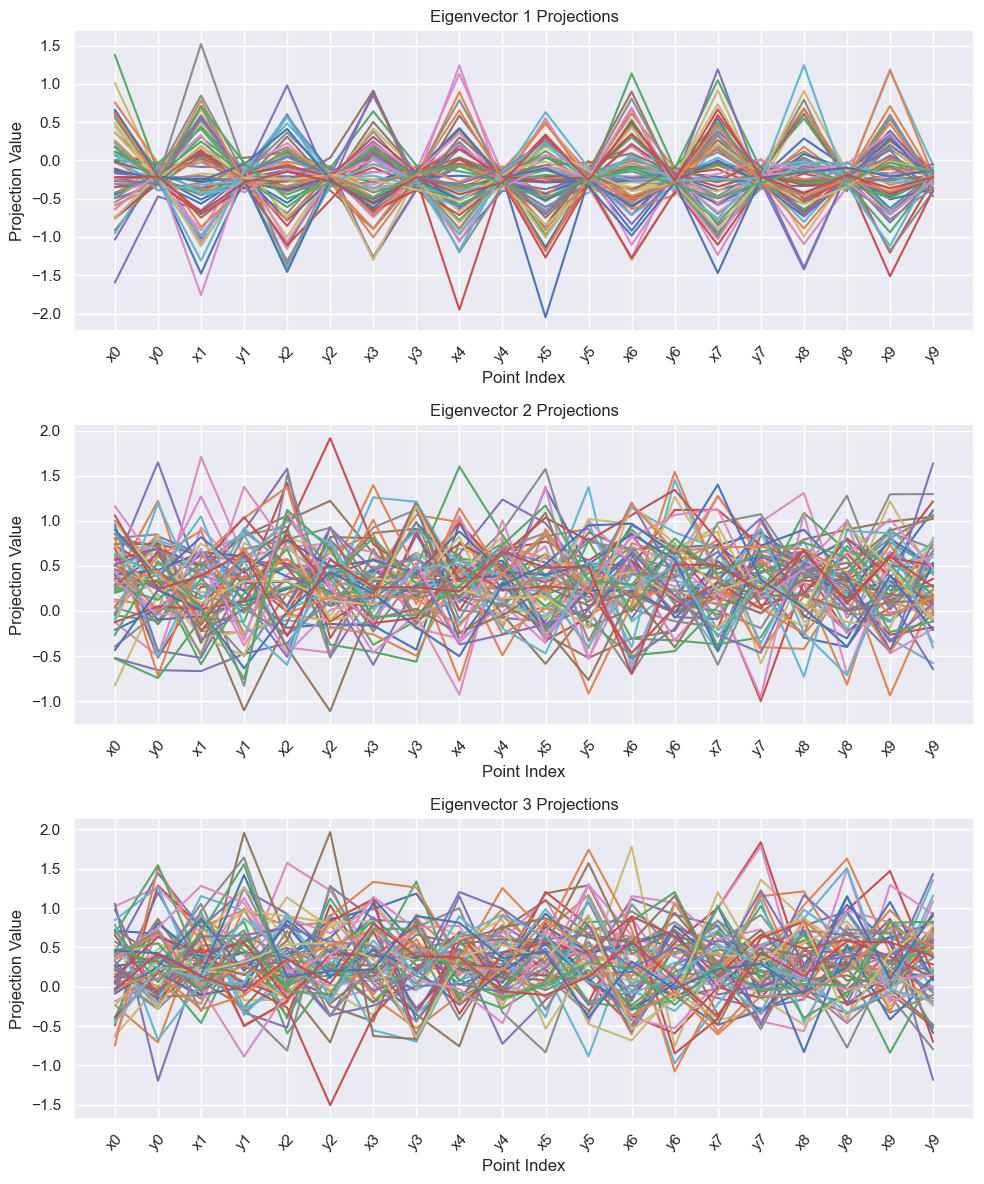

In [266]:
n_features = 64
n_sequences = 10
n_points = 10
n_eigenvectors = 3

eigs_subset = eigs[:n_eigenvectors, :]

# Adjusted function for projection, now using PyTorch operations.
def project_eigenvector_torch(eig_input, eig_vector):
    eig_vector_norm = eig_vector / eig_vector.norm()
    projections = torch.matmul(eig_input, eig_vector_norm)
    return projections

# Creating the plots again, this time with x-axis labels from 1 to 20.
fig, axes = plt.subplots(n_eigenvectors, 1, figsize=(10, n_eigenvectors * 4))

for i, eig_vector in enumerate(eigs_subset):
    projections = torch.stack([project_eigenvector_torch(eig_input[seq].cpu(), eig_vector.cpu()) for seq in range(eig_input.shape[0])])
    for seq in range(eig_input.shape[0]):
        axes[i].plot(range(0, n_points * 2), projections[seq, :(n_points * 2)].detach().numpy(), label=f'Sequence {seq+1}')
    axes[i].set_title(f'Eigenvector {i+1} Projections')
    axes[i].set_xlabel('Point Index')
    axes[i].set_ylabel('Projection Value')
    #axes[i].set_xticks(range(1, 21))  # Setting x-axis to show labels from 1 to 20.
    #axes[i].legend(loc='upper right', prop={'size': 6}, ncol=2)
    axis_labels = [f'x{i//2}' if i % 2 == 0 else f'y{i//2}' for i in range(0, n_points * 2)]
    axes[i].set_xticks(range(n_points * 2), labels=axis_labels, rotation=45)  # Rotation for better readability
    #axes[i].yticks(range(20), labels=axis_labels)

plt.tight_layout()
plt.show()


In [249]:
significant_eigenvalue_threshold = 0.1
head_score = 0


In [251]:
AB_matrix = model.OV.AB[0, 0]
eig_results = torch.linalg.eig(AB_matrix)
eigenvalues, eigenvectors = eig_results.eigenvalues, eig_results.eigenvectors.to(torch.float32)
significant_idxs = torch.where(torch.abs(eigenvalues) > significant_eigenvalue_threshold)[0]
significant_eigenvectors = eigenvectors[:, significant_idxs]
for i, eig_vector in enumerate(significant_eigenvectors.T):
    # Compute projections
    projections = torch.stack([project_eigenvector_torch(eig_input[seq], eig_vector) for seq in range(eig_input.shape[0])])
    even_indices = torch.arange(0, conf.training.curriculum.points.end - 1, step=2) # -1 because the last x does not have a y value
    odd_indices = torch.arange(1, conf.training.curriculum.points.end, step=2)
    even_projections = torch.abs(projections[:, even_indices]).sum()
    odd_projections = torch.abs(projections[:, odd_indices]).sum()
    head_score += (even_projections / odd_projections)

In [254]:
head_score / i

tensor(1.9764, grad_fn=<DivBackward0>)

## Attention

In [156]:
_, eig_cache = model.run_with_cache(eig_input)

import math
eig_attn = eig_cache['blocks.0.attn.hook_attn_scores'][0, 0][:20, :20].cpu()
eig_attn = eig_attn / math.sqrt(32) # idk maybe n_heads
eig_attn = eig_attn.softmax(dim=-1)

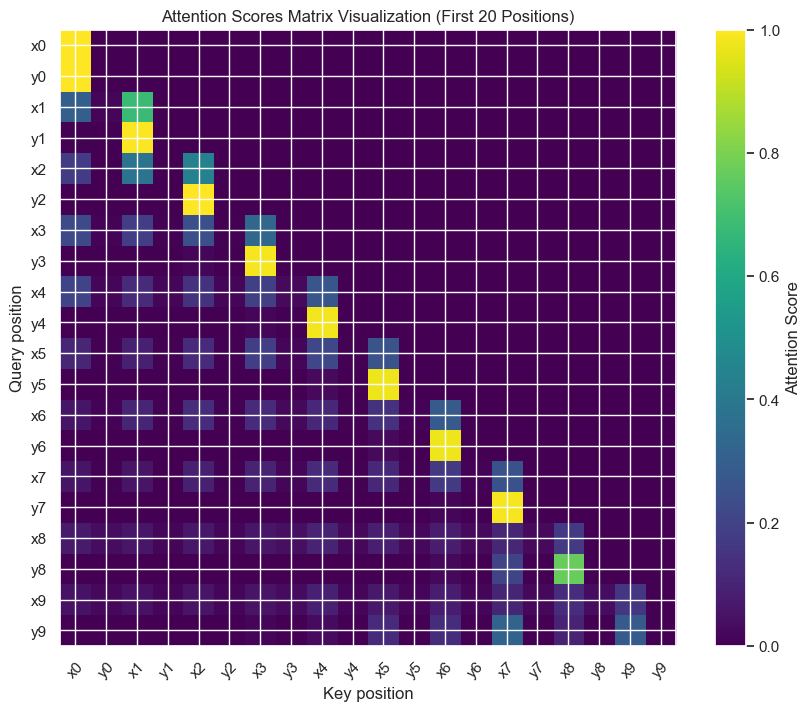

In [157]:
# Adjusting the axis labels to display "x0", "y0", "x1", "y1", etc., for the visualization of the attention scores matrix.

# Generating labels for the axes based on the requested pattern.
axis_labels = [f'x{i//2}' if i % 2 == 0 else f'y{i//2}' for i in range(20)]

plt.figure(figsize=(10, 8))
plt.imshow(eig_attn, cmap='viridis')
plt.colorbar(label='Attention Score')
plt.title('Attention Scores Matrix Visualization (First 20 Positions)')
plt.xlabel('Key position')
plt.ylabel('Query position')

# Applying the custom labels to the axes.
plt.xticks(range(20), labels=axis_labels, rotation=45)  # Rotation for better readability
plt.yticks(range(20), labels=axis_labels)

plt.show()


In [246]:
odd_indices = torch.arange(1, eig_attn.shape[0], step=2)

selected_elements = eig_attn[odd_indices, odd_indices - 1]

mean_of_elements = selected_elements.mean()
mean_of_elements

tensor(0.8943)

## Now anayse patch dataset

In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

oneD_df = pd.read_csv('1D_a_0_0_patch_dataset.txt', sep=' ', header=None, names=['x1', 'x2', 'x3', 'y'])

In [189]:
oneD_df

,x1,x2,x3,y
0,0.115302,0.115302,0.115302,1.888465
1,-0.880657,-0.880657,-0.880657,2.064395
2,-1.638817,-1.638817,-1.638817,2.299792
3,1.648512,1.648512,1.648512,0.323278
4,-0.522765,-0.522765,-0.522765,1.770356
...,...,...,...,...
13495,-0.466475,-0.466475,-0.466475,1.783358
13496,0.397329,0.397329,0.397329,1.229195
13497,1.789726,1.789726,1.789726,0.272120
13498,-1.615297,-1.615297,-1.615297,2.303450


In [191]:
x1_correlation, x1_p_value = pearsonr(oneD_df['x1'], oneD_df['y'])
x1_correlation, x1_p_value

(-0.883586379864995, 0.0)

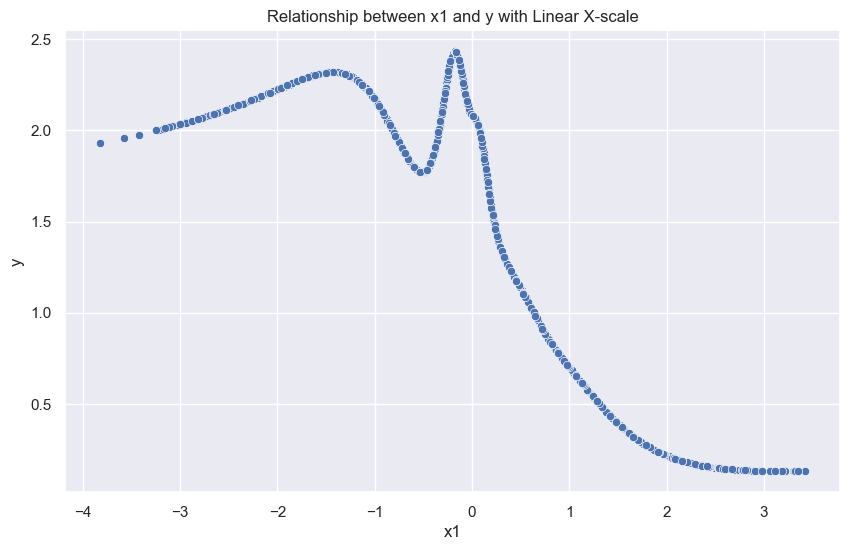

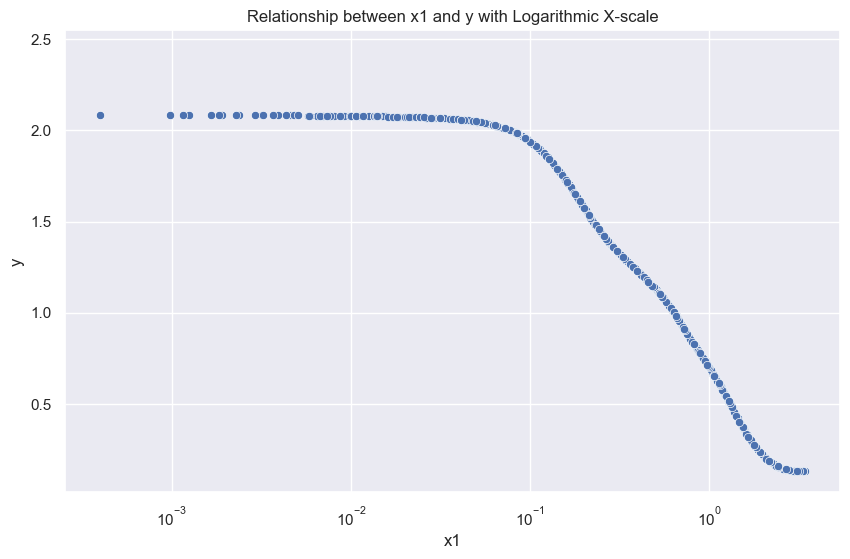

In [199]:
plt.figure(figsize=(10, 6))  # Optional: Adjust figure size
sns.scatterplot(data=oneD_df, x='x1', y='y')
#plt.xscale('log')  # Set the x-axis to a logarithmic scale
plt.title(f'Relationship between x1 and y with Linear X-scale')
plt.xlabel('x1')
plt.ylabel('y')
plt.show()

plt.figure(figsize=(10, 6))  # Optional: Adjust figure size
sns.scatterplot(data=oneD_df, x='x1', y='y')
plt.xscale('log')  # Set the x-axis to a logarithmic scale
plt.title(f'Relationship between x1 and y with Logarithmic X-scale')
plt.xlabel('x1')
plt.ylabel('y')
plt.show()

## multi dimentional graph

In [193]:
df = pd.read_csv('a_0_0_patch_dataset.txt', sep=' ', header=None, names=['x1', 'x2', 'x3', 'y'])

In [198]:
df

,x1,x2,x3,y
0,-0.439910,1.776573,-1.079225,1.670422
1,-2.043214,0.336139,0.485976,2.403076
2,0.492873,-0.953589,0.629337,1.419429
3,-0.303723,0.336849,-0.315471,2.198394
4,-0.513472,-1.600210,-0.847360,1.823390
...,...,...,...,...
13507,-0.287363,0.528618,-0.220909,1.915849
13508,-0.823071,0.159072,0.764152,1.913076
13509,-0.788163,1.529038,0.146317,1.549600
13510,-0.209261,-1.052511,-0.446193,1.556560


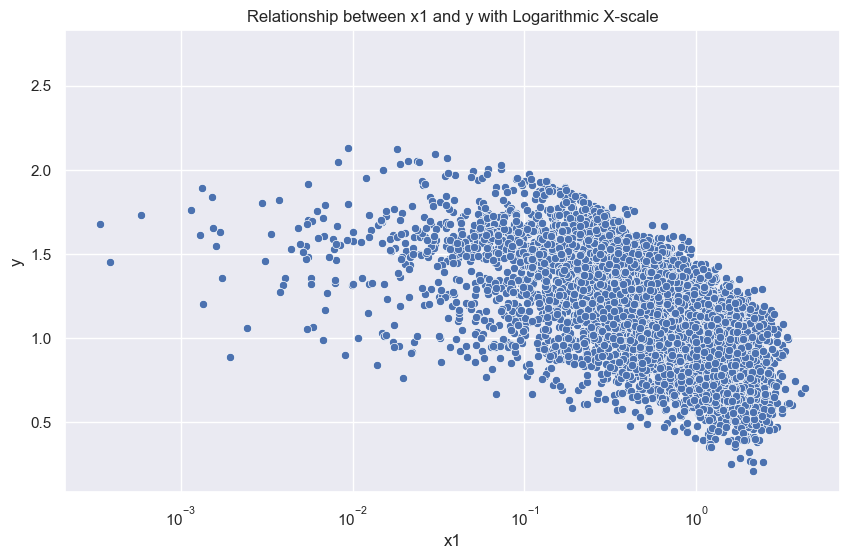

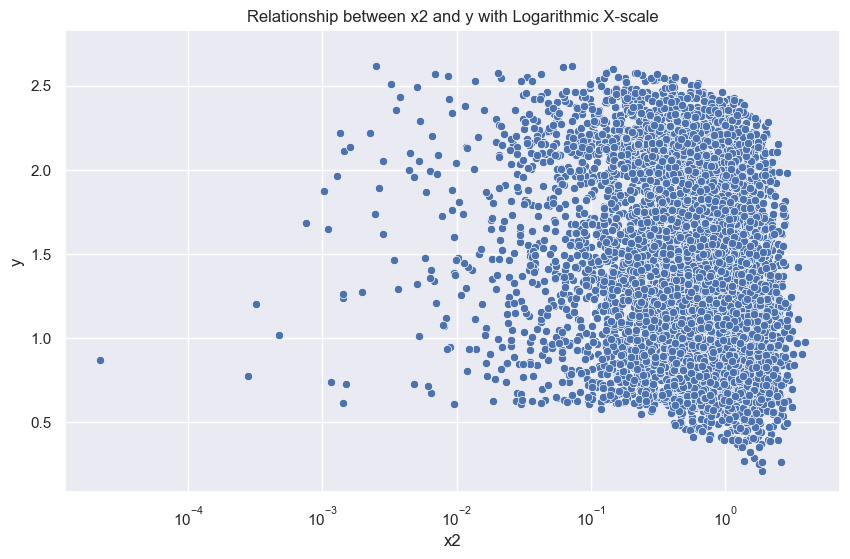

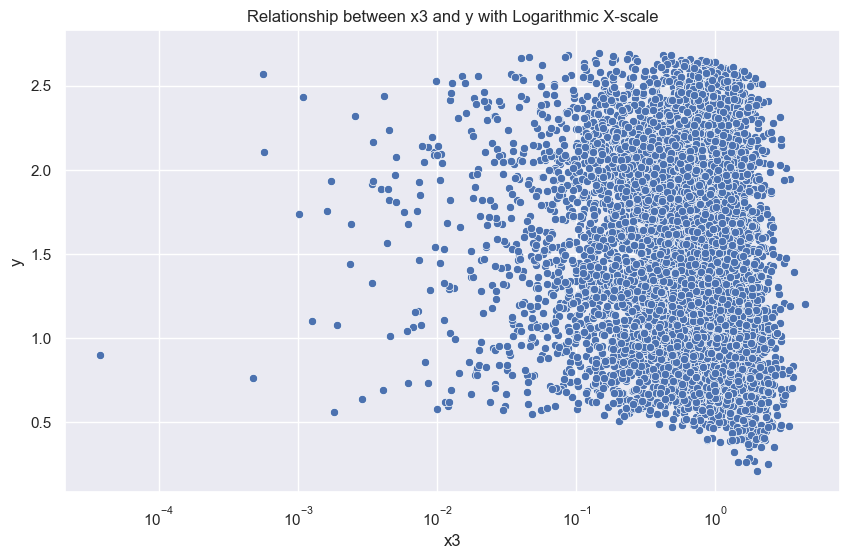

In [194]:
for col in ['x1', 'x2', 'x3']:
    plt.figure(figsize=(10, 6))  # Optional: Adjust figure size
    sns.scatterplot(data=df, x=col, y='y')
    plt.xscale('log')  # Set the x-axis to a logarithmic scale
    plt.title(f'Relationship between {col} and y with Logarithmic X-scale')
    plt.xlabel(col)
    plt.ylabel('y')
    plt.show()

In [195]:
x1_correlation, x1_p_value = pearsonr(df['x1'], df['y'])
x1_correlation, x1_p_value

(-0.8591959247715821, 0.0)

In [196]:
x2_correlation, x2_p_value = pearsonr(df['x2'], df['y'])
x2_correlation, x2_p_value

(-0.30171180917339524, 2.284808687413722e-282)

In [197]:
x3_correlation, x3_p_value = pearsonr(df['x3'], df['y'])
x3_correlation, x3_p_value

(-0.2057891986722223, 3.775269839175843e-129)

## Embedding analysis

In [201]:
clean_input, clean_xs, clean_ys, _ = get_data(conf, read_in_weight, read_in_bias)
clean_output, clean_cache = model.run_with_cache(clean_input)
clean_output = clean_output[:, ::2, 0][:, torch.arange(ys.shape[1])].cpu()  

corrupt_input, corrupt_xs, corrupt_ys, _ = get_data(conf, read_in_weight, read_in_bias)
corrupt_output, corrupt_cache = model.run_with_cache(corrupt_input)
corrupt_output = corrupt_output[:, ::2, 0][:, torch.arange(ys.shape[1])].cpu()

hooks

In [202]:
def xs_attn0_patching_hook(
    resid_pre: Float[torch.Tensor, "batch pos d_model"],
    hook: HookPoint,
) -> Float[torch.Tensor, "batch pos d_model"]:
    # Each HookPoint has a name attribute giving the name of the hook.
    corrupt_embedding = corrupt_cache['blocks.0.hook_resid_pre']
    clean_embedding = clean_cache['blocks.0.hook_resid_pre']

    # If 1::2 patch in ys, if ::2 patch in xs
    patch_ys = False

    if patch_ys:
        resid_pre[:, 1::2, 0, :] = resid_pre[:, 1::2, 0, :] - clean_embedding[:, 1::2, :] + corrupt_embedding[:, 1::2, :]
    else: # patch xs
        resid_pre[:, ::2, 0, :] = resid_pre[:, ::2, 0, :] - clean_embedding[:, ::2, :] + corrupt_embedding[:, ::2, :]
    return resid_pre
    
def ys_attn0_patching_hook(
    resid_pre: Float[torch.Tensor, "batch pos d_model"],
    hook: HookPoint,
) -> Float[torch.Tensor, "batch pos d_model"]:
    # Each HookPoint has a name attribute giving the name of the hook.
    corrupt_embedding = corrupt_cache['blocks.0.hook_resid_pre']
    clean_embedding = clean_cache['blocks.0.hook_resid_pre']

    # If 1::2 patch in ys, if ::2 patch in xs
    patch_ys = True

    if patch_ys:
        resid_pre[:, 1::2, 0, :] = resid_pre[:, 1::2, 0, :] - clean_embedding[:, 1::2, :] + corrupt_embedding[:, 1::2, :]
    else: # patch xs
        resid_pre[:, ::2, 0, :] = resid_pre[:, ::2, 0, :] - clean_embedding[:, ::2, :] + corrupt_embedding[:, ::2, :]
    return resid_pre

def xs_attn1_patching_hook(
    resid_pre: Float[torch.Tensor, "batch pos d_model"],
    hook: HookPoint,
) -> Float[torch.Tensor, "batch pos d_model"]:
    # Each HookPoint has a name attribute giving the name of the hook.
    corrupt_embedding = corrupt_cache['blocks.0.hook_resid_pre']
    clean_embedding = clean_cache['blocks.0.hook_resid_pre']

    # If 1::2 patch in ys, if ::2 patch in xs
    patch_ys = False

    if patch_ys:
        resid_pre[:, 1::2, 1, :] = resid_pre[:, 1::2, 1, :] - clean_embedding[:, 1::2, :] + corrupt_embedding[:, 1::2, :]
    else: # patch xs
        resid_pre[:, ::2, 1, :] = resid_pre[:, ::2, 1, :] - clean_embedding[:, ::2, :] + corrupt_embedding[:, ::2, :]
    return resid_pre
    
def ys_attn1_patching_hook(
    resid_pre: Float[torch.Tensor, "batch pos d_model"],
    hook: HookPoint,
) -> Float[torch.Tensor, "batch pos d_model"]:
    # Each HookPoint has a name attribute giving the name of the hook.
    corrupt_embedding = corrupt_cache['blocks.0.hook_resid_pre']
    clean_embedding = clean_cache['blocks.0.hook_resid_pre']

    # If 1::2 patch in ys, if ::2 patch in xs
    patch_ys = True

    if patch_ys:
        resid_pre[:, 1::2, 1, :] = resid_pre[:, 1::2, 1, :] - clean_embedding[:, 1::2, :] + corrupt_embedding[:, 1::2, :]
    else: # patch xs
        resid_pre[:, ::2, 1, :] = resid_pre[:, ::2, 1, :] - clean_embedding[:, ::2, :] + corrupt_embedding[:, ::2, :]
    return resid_pre

def xs_residual_stream_patching_hook(
    resid_pre: Float[torch.Tensor, "batch pos d_model"],
    hook: HookPoint,
) -> Float[torch.Tensor, "batch pos d_model"]:
    # Each HookPoint has a name attribute giving the name of the hook.
    corrupt_embedding = corrupt_cache['blocks.0.hook_resid_pre']
    clean_embedding = clean_cache['blocks.0.hook_resid_pre']

    # If 1::2 patch in ys, if ::2 patch in xs
    patch_ys = False

    if patch_ys:
        resid_pre[:, 1::2, :] = resid_pre[:, 1::2, :] - clean_embedding[:, 1::2, :] + corrupt_embedding[:, 1::2, :]
    else: # patch xs
        resid_pre[:, ::2, :] = resid_pre[:, ::2, :] - clean_embedding[:, ::2, :] + corrupt_embedding[:, ::2, :]
    return resid_pre

def ys_residual_stream_patching_hook(
    resid_pre: Float[torch.Tensor, "batch pos d_model"],
    hook: HookPoint,
) -> Float[torch.Tensor, "batch pos d_model"]:
    # Each HookPoint has a name attribute giving the name of the hook.
    corrupt_embedding = corrupt_cache['blocks.0.hook_resid_pre']
    clean_embedding = clean_cache['blocks.0.hook_resid_pre']

    # If 1::2 patch in ys, if ::2 patch in xs
    patch_ys = True

    if patch_ys:
        resid_pre[:, 1::2, :] = resid_pre[:, 1::2, :] - clean_embedding[:, 1::2, :] + corrupt_embedding[:, 1::2, :]
    else: # patch xs
        resid_pre[:, ::2, :] = resid_pre[:, ::2, :] - clean_embedding[:, ::2, :] + corrupt_embedding[:, ::2, :]
    return resid_pre

In [221]:
xs_ys_embed_expriment = pd.DataFrame(columns=['Activation', 'Ablating (xs/ys)', 'Ablated Loss'])

In [222]:
activations_using_embedding = ['blocks.0.hook_q_input', 'blocks.0.hook_k_input', 'blocks.0.hook_v_input', 'blocks.0.hook_mlp_in', 'blocks.1.hook_q_input', 'blocks.1.hook_k_input', 'blocks.1.hook_v_input', 'blocks.1.hook_mlp_in', 'blocks.2.hook_q_input', 'blocks.2.hook_k_input', 'blocks.2.hook_v_input', 'blocks.2.hook_mlp_in']

In [223]:
with torch.no_grad():
    for activation in activations_using_embedding:
        model.reset_hooks()

        if activation.split('.')[2] == 'hook_mlp_in':
            # we're using mlp

            xs_patched_preds = model.run_with_hooks(clean_input, fwd_hooks=[
                (utils.get_act_name(activation), xs_residual_stream_patching_hook)
            ])[:, ::2, 0][:, torch.arange(clean_ys.shape[1])].cpu()
            xs_ablated_loss = validation_metric(xs_patched_preds, clean_ys, False, 'cpu')

            model.reset_hooks()

            ys_patched_preds = model.run_with_hooks(clean_input, fwd_hooks=[
                (utils.get_act_name(activation), ys_residual_stream_patching_hook)
            ])[:, ::2, 0][:, torch.arange(clean_ys.shape[1])].cpu()
            ys_ablated_loss = validation_metric(ys_patched_preds, clean_ys, False, 'cpu')

            model.reset_hooks()

            xs_ys_embed_expriment.loc[len(xs_ys_embed_expriment)] = {'Activation': activation, 'Ablating (xs/ys)': 'xs', 'Ablated Loss': xs_ablated_loss}
            xs_ys_embed_expriment.loc[len(xs_ys_embed_expriment)] = {'Activation': activation, 'Ablating (xs/ys)': 'ys', 'Ablated Loss': ys_ablated_loss}
        else:
            # using attn

            # head 0
            # xs
            
            head_0_xs_patched_preds = model.run_with_hooks(clean_input, fwd_hooks=[
                (utils.get_act_name(activation), xs_attn0_patching_hook)
            ])[:, ::2, 0][:, torch.arange(clean_ys.shape[1])].cpu()
            head_0_xs_ablated_loss = validation_metric(head_0_xs_patched_preds, clean_ys, False, 'cpu')

            model.reset_hooks()

            # ys
            head_0_ys_patched_preds = model.run_with_hooks(clean_input, fwd_hooks=[
                (utils.get_act_name(activation), ys_attn0_patching_hook)
            ])[:, ::2, 0][:, torch.arange(clean_ys.shape[1])].cpu()
            head_0_ys_ablated_loss = validation_metric(head_0_ys_patched_preds, clean_ys, False, 'cpu')

            model.reset_hooks()

            # head 1
            # xs
            head_1_xs_patched_preds = model.run_with_hooks(clean_input, fwd_hooks=[
                (utils.get_act_name(activation), xs_attn1_patching_hook)
            ])[:, ::2, 0][:, torch.arange(clean_ys.shape[1])].cpu()
            head_1_xs_ablated_loss = validation_metric(head_1_xs_patched_preds, clean_ys, False, 'cpu')

            model.reset_hooks()
            
            # ys
            head_1_ys_patched_preds = model.run_with_hooks(clean_input, fwd_hooks=[
                (utils.get_act_name(activation), ys_attn1_patching_hook)
            ])[:, ::2, 0][:, torch.arange(clean_ys.shape[1])].cpu()
            head_1_ys_ablated_loss = validation_metric(head_1_ys_patched_preds, clean_ys, False, 'cpu')

            model.reset_hooks()

            xs_ys_embed_expriment.loc[len(xs_ys_embed_expriment)] = {'Activation': activation + '_head_0', 'Ablating (xs/ys)': 'xs', 'Ablated Loss': head_0_xs_ablated_loss}
            xs_ys_embed_expriment.loc[len(xs_ys_embed_expriment)] = {'Activation': activation + '_head_0', 'Ablating (xs/ys)': 'ys', 'Ablated Loss': head_0_ys_ablated_loss}

            xs_ys_embed_expriment.loc[len(xs_ys_embed_expriment)] = {'Activation': activation + '_head_1', 'Ablating (xs/ys)': 'xs', 'Ablated Loss': head_1_xs_ablated_loss}
            xs_ys_embed_expriment.loc[len(xs_ys_embed_expriment)] = {'Activation': activation + '_head_1', 'Ablating (xs/ys)': 'ys', 'Ablated Loss': head_1_ys_ablated_loss}


blocks.0.hook_mlp_in
blocks.1.hook_mlp_in
blocks.2.hook_mlp_in


In [224]:
xs_ys_embed_expriment.sort_values(by='Ablated Loss', ascending=False)

,Activation,Ablating (xs/ys),Ablated Loss
12,blocks.0.hook_mlp_in,xs,12.859111
8,blocks.0.hook_v_input_head_0,xs,11.165280
37,blocks.2.hook_v_input_head_0,ys,3.412644
13,blocks.0.hook_mlp_in,ys,3.110020
14,blocks.1.hook_q_input_head_0,xs,3.029332
16,blocks.1.hook_q_input_head_1,xs,2.926548
10,blocks.0.hook_v_input_head_1,xs,2.468683
2,blocks.0.hook_q_input_head_1,xs,2.395895
28,blocks.2.hook_q_input_head_0,xs,2.264822
6,blocks.0.hook_k_input_head_1,xs,2.210049


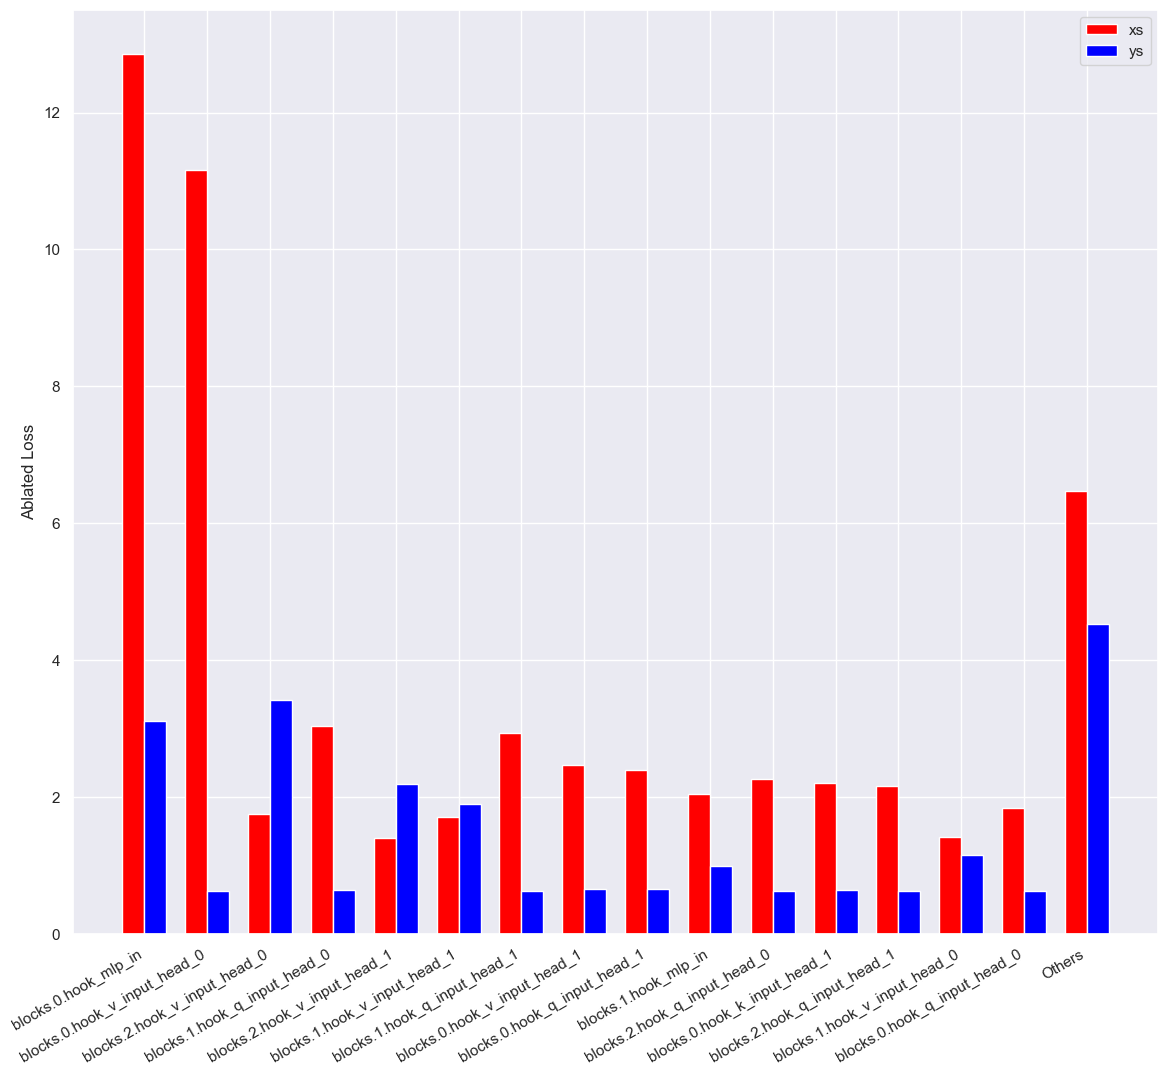

In [231]:
width = 0.35
top_n = 15

xs_ys_embed_expriment['Total Ablated Loss'] = xs_ys_embed_expriment.groupby(['Activation', 'Ablating (xs/ys)'])['Ablated Loss'].transform('sum')

# Then, create a pivot table to separate 'xs' and 'ys' losses for each activation
pivot_df = xs_ys_embed_expriment.pivot_table(index='Activation', columns='Ablating (xs/ys)', values='Total Ablated Loss', aggfunc='first')

# Calculate the sum of ablated losses (xs + ys) for sorting purposes
pivot_df['Sum Loss'] = pivot_df.sum(axis=1)

# Sort by 'Sum Loss' in descending order
sorted_pivot_df = pivot_df.sort_values(by='Sum Loss', ascending=False)

# Keep the top 20 activations and merge others into 'Others' category
top_n_pivot_df = sorted_pivot_df.iloc[:top_n, :2]
others_df = pd.DataFrame(sorted_pivot_df.iloc[top_n:, :2].sum()).transpose()
others_df.index = ['Others']

# Combine the top 10 activations dataframe and the "Others" dataframe for plotting
plot_df_with_others = pd.concat([top_n_pivot_df, others_df])

# Adjust positions for the updated number of categories
positions_with_others = range(len(plot_df_with_others))

fig, ax = plt.subplots(figsize=(14, 12))

# Plot vertical bars for xs and ys side by side, including 'Others'
ax.bar([p - width/2 for p in positions_with_others], plot_df_with_others['xs'], width, color='red', label='xs')
ax.bar([p + width/2 for p in positions_with_others], plot_df_with_others['ys'], width, color='blue', label='ys')

ax.set_ylabel('Ablated Loss')
# ax.set_title('Top Activations Plus Others by Ablated Loss for xs and ys')
ax.set_xticks(positions_with_others)
ax.set_xticklabels(plot_df_with_others.index, rotation=30, ha="right")
ax.legend(loc='upper right')

plt.savefig('activations_ablated_loss.png')


plt.show()

# Probe

In [285]:
in_features = 64 * 64 * 3 
out_features = 5 

probe = nn.Linear(in_features=in_features, out_features=out_features)

In [286]:
state = torch.load("./probe_state.pt", map_location=torch.device('cpu'))

probe.load_state_dict(state["model_state_dict"])

<All keys matched successfully>

In [287]:
def index_to_original(index, d_model, position, layers=3):
    size_per_layer = d_model * position
    layer = index // size_per_layer
    index_within_layer = index % size_per_layer
    pos = index_within_layer // d_model
    dim = index_within_layer % d_model
    return layer % layers, pos, dim

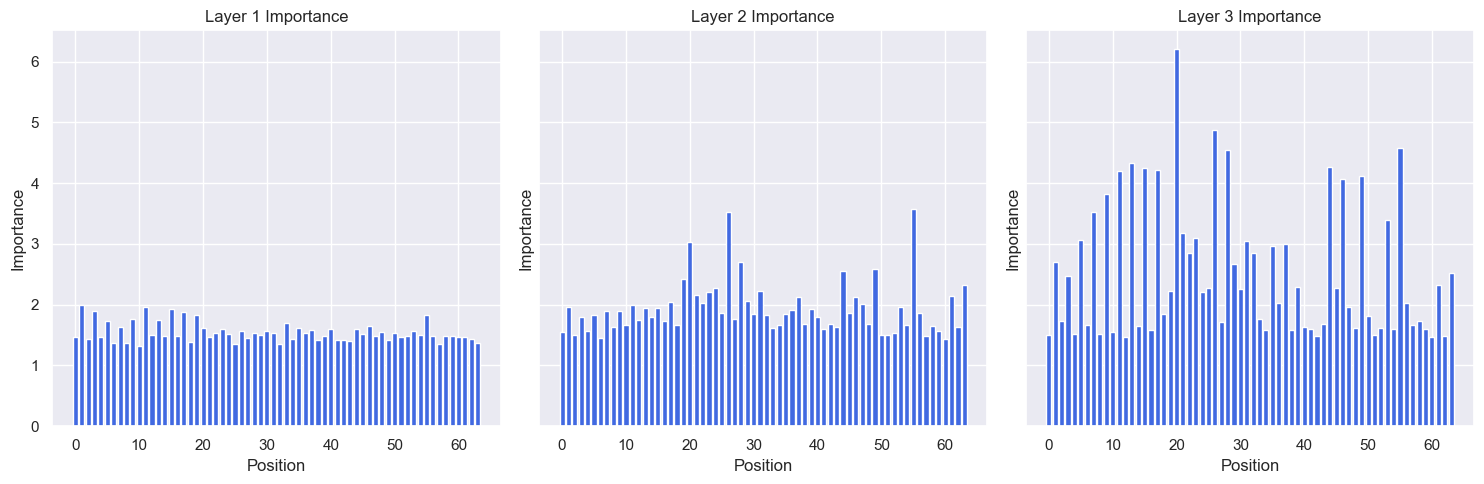

In [288]:
import numpy as np
import matplotlib.pyplot as plt

# Example setup
d_model = 64
position = 64
layers = 3  # Assuming 3 layers

# Assume weights is a [1, N] array where N = d_model * position * layers
weights = probe.weight.data.abs().numpy().flatten()

# Calculate importance for each position within each layer
importance = np.zeros((layers, position))

for index, weight in enumerate(weights):
    layer, pos, _ = index_to_original(index, d_model, position, layers)
    importance[layer, pos] += weight  # Summing the importance of weights for each position

# Now, importance[layer, pos] holds the summed absolute weight importance for each position in each layer

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=layers, figsize=(15, 5), sharey=True)
for i in range(layers):
    axes[i].bar(range(position), importance[i, :], color='royalblue')
    axes[i].set_title(f'Layer {i+1} Importance')
    axes[i].set_xlabel('Position')
    axes[i].set_ylabel('Importance')
plt.tight_layout()
plt.show()

In [289]:
loss_func= nn.MSELoss()

probe_input, _, probe_ys, probe_weights = get_data(conf, read_in_weight, read_in_bias)
_, probe_cache = model.run_with_cache(probe_input)

mlp_activations = get_acts(probe_cache)
probe_output = probe(mlp_activations)

loss = loss_func(probe_output, probe_weights.squeeze(-1))

tensor(0.4005, grad_fn=<MseLossBackward0>)

In [290]:
corrupt_probe_input, _, _, corrupt_probe_weights = get_data(conf, read_in_weight, read_in_bias)

_, corrupt_probe_cache = model.run_with_cache(corrupt_probe_input)

corrupt_mlp_activations = get_acts(corrupt_probe_cache)

In [291]:
def compute_loss_with_replacement(base_activations, corrupt_activations, probe, loss_func, weights, index):

    modified_activations = base_activations.clone()  # Clone to avoid modifying the original tensor
    modified_activations[:, index] = corrupt_activations[:, index]  # Replace the specified dimension
    
    # Compute the output and loss with the modified activations
    output = probe(modified_activations)
    return loss_func(output, weights.squeeze(-1)).item()


In [293]:
base_loss = loss_func(probe_output, probe_weights.squeeze(-1)).item()

In [296]:
# Initial setup
d_model = 64  # Dimensionality of the model
position = 64  # Number of positions in the sequence
num_dimensions = d_model * position * 3  # Total dimensions for 3 MLPs
loss_differences = np.zeros(num_dimensions)

# Iterate over each dimension and compute the loss difference
for i in tqdm(range(num_dimensions)):
    loss_differences[i] = compute_loss_with_replacement(mlp_activations, corrupt_mlp_activations, probe, loss_func, probe_weights, i) - base_loss

100%|██████████| 12288/12288 [00:07<00:00, 1739.88it/s]


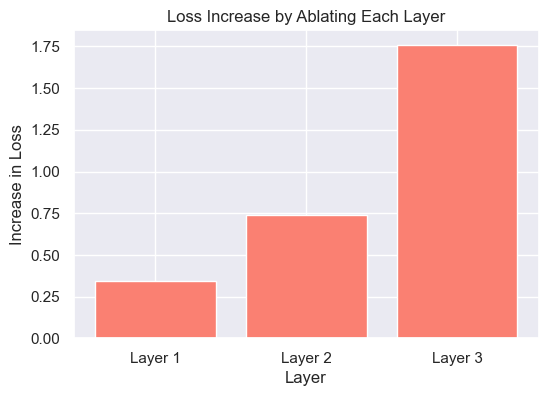

In [298]:
layer_loss_increments = np.zeros(layers)  # There are 3 layers

for layer in range(layers):
    modified_activations = mlp_activations.clone()
    
    # Calculate the start and end indices for this layer
    start_index = layer * d_model * position
    end_index = start_index + d_model * position
    
    # Ablate the entire layer
    modified_activations[:, start_index:end_index] = corrupt_mlp_activations[:, start_index:end_index]
    
    current_output = probe(modified_activations)
    layer_loss_increments[layer] = loss_func(current_output, probe_weights.squeeze(-1)).item() - base_loss

# Plotting the loss increase by ablating each layer
plt.figure(figsize=(6, 4))
plt.bar(['Layer 1', 'Layer 2', 'Layer 3'], layer_loss_increments, color='salmon')
plt.title('Loss Increase by Ablating Each Layer')
plt.xlabel('Layer')
plt.ylabel('Increase in Loss')
plt.show()

# Search induction heads

In [302]:
import einops
# We make a tensor to store the induction score for each head. We put it on the model's device to avoid needing to move things between the GPU and CPU, which can be slow.
induction_score_store = torch.zeros((model.cfg.n_layers, model.cfg.n_heads), device=model.cfg.device)
def induction_score_hook(
    pattern: Float[torch.Tensor, "batch head_index dest_pos source_pos"],
    hook: HookPoint,
):
    # We take the diagonal of attention paid from each destination position to source positions seq_len-1 tokens back
    # (This only has entries for tokens with index>=seq_len)
    induction_stripe = pattern.diagonal(dim1=-2, dim2=-1, offset=1-64)
    # Get an average score per head
    induction_score = einops.reduce(induction_stripe, "batch head_index position -> head_index", "mean")
    # Store the result.
    induction_score_store[hook.layer(), :] = induction_score

# We make a boolean filter on activation names, that's true only on attention pattern names.
pattern_hook_names_filter = lambda name: name.endswith("pattern")

model.run_with_hooks(
    clean_input, 
    return_type=None, # For efficiency, we don't need to calculate the logits
    fwd_hooks=[(
        pattern_hook_names_filter,
        induction_score_hook
    )]
)

imshow(induction_score_store, xaxis="Head", yaxis="Layer", title="Induction Score by Head", zmax=1.0, zmin=-1.0)

In [304]:
induction_score_store.mean()

tensor(0.0172, grad_fn=<MeanBackward0>)

In [305]:
def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

OV_circuit_all_heads = model.OV
OV_circuit_all_heads_eigenvalues = OV_circuit_all_heads.eigenvalues 

OV_copying_score = OV_circuit_all_heads_eigenvalues.sum(dim=-1).real / OV_circuit_all_heads_eigenvalues.abs().sum(dim=-1)
imshow(utils.to_numpy(OV_copying_score), xaxis="Head", yaxis="Layer", title="OV Copying Score for each head in fully trained model", zmax=1.0, zmin=-1.0)

## Norm scores

In [306]:
excluded_loss, restricted_loss, selected_head, total_scores = search_heads_get_loss(model, conf, read_in_weight, read_in_bias)

In [307]:
norm_scores = total_scores.detach().numpy()

In [310]:
imshow(total_scores, xaxis="Head", yaxis="Layer", title="Norm Score for each head", zmax=1.0, zmin=0)

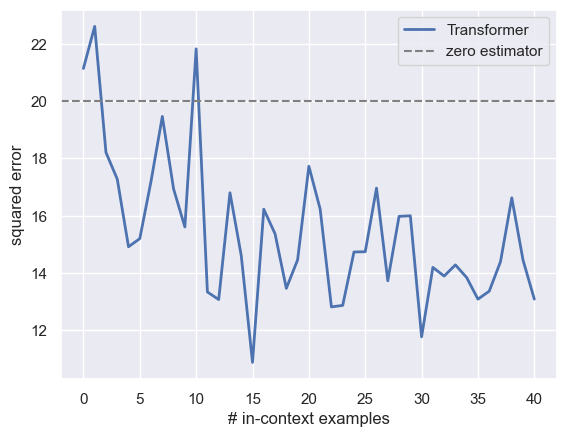

(Munch({'model': Munch({'family': 'gpt2', 'n_dims': 20, 'n_embd': 128, 'n_head': 2, 'n_layer': 3, 'n_positions': 101, 'dropout': 0}), 'out_dir': './models', 'test_run': False, 'training': Munch({'batch_size': 128, 'curriculum': Munch({'dims': Munch({'end': 20, 'inc': 1, 'interval': 1000000000, 'start': 20}), 'points': Munch({'end': 41, 'inc': 1, 'interval': 1000000000, 'start': 41})}), 'data': 'gaussian', 'keep_every_steps': 100000, 'keep_every_steps_until_phase_transition': 1000, 'learning_rate': 0.0001, 'num_tasks': None, 'resume_id': None, 'save_every_steps': 500, 'task': 'linear_regression', 'task_kwargs': Munch({}), 'train_steps': 500000, 'num_training_examples': None, 'weight_decay': 0}), 'wandb': Munch({'entity': 'marcomolinari4', 'log_every_steps': 500, 'name': None, 'notes': '', 'project': 'train toy regressor'})}),
 (14.381162, 15.446587))

In [331]:
before_path = './weights_before/' # at epoch 71k

before_model, before_conf = get_model_from_run(before_path)

before_model, before_read_in_weights, before_read_in_bias = hook_model(before_model, before_conf)
before_conf, test_model(device, before_conf, before_model, before_read_in_weights, before_read_in_bias, True)

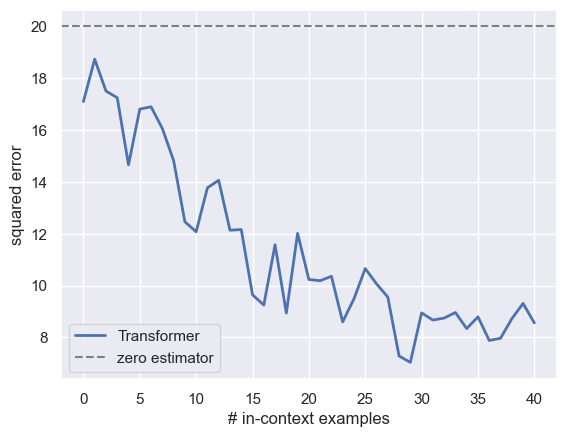

(Munch({'model': Munch({'family': 'gpt2', 'n_dims': 20, 'n_embd': 128, 'n_head': 2, 'n_layer': 3, 'n_positions': 101, 'dropout': 0}), 'out_dir': './models', 'test_run': False, 'training': Munch({'batch_size': 128, 'curriculum': Munch({'dims': Munch({'end': 20, 'inc': 1, 'interval': 1000000000, 'start': 20}), 'points': Munch({'end': 41, 'inc': 1, 'interval': 1000000000, 'start': 41})}), 'data': 'gaussian', 'keep_every_steps': 100000, 'keep_every_steps_until_phase_transition': 1000, 'learning_rate': 0.0001, 'num_tasks': None, 'resume_id': None, 'save_every_steps': 500, 'task': 'linear_regression', 'task_kwargs': Munch({}), 'train_steps': 500000, 'num_training_examples': None, 'weight_decay': 0}), 'wandb': Munch({'entity': 'marcomolinari4', 'log_every_steps': 500, 'name': None, 'notes': '', 'project': 'train toy regressor'})}),
 (8.487159, 11.372381))

In [332]:
after_path = './weights_after/' # at epoch 82k

after_model, after_conf = get_model_from_run(after_path)

after_model, after_read_in_weights, after_read_in_bias = hook_model(after_model, after_conf)
after_conf, test_model(device, after_conf, after_model, after_read_in_weights, after_read_in_bias, True)

In [334]:
_, _, selected_head, total_scores = search_heads_get_loss(after_model, after_conf, after_read_in_weights, after_read_in_bias)

In [335]:
selected_head, total_scores

((0, 0),
 tensor([[1.0000, 0.5820],
         [0.3024, 0.6031],
         [0.0330, 0.1373]], grad_fn=<MeanBackward1>))